In [1]:
import numpy as np
import cv2
from PIL import Image
import torch
from magic_pen.config import SEED
import pytorch_lightning as pl
import pandas as pd
import os
from copy import deepcopy
import torch.nn.functional as F
from torchmetrics import Metric
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt

from magic_pen.utils_io import load_levircd_sample

from magic_pen.data.loader import BiTemporalDataset
from commons.constants import NamedDataset
from magic_pen.data.loader import BiTemporalDataset
from magic_pen.data.process import DefaultTransform

from segment_any_change.masks.mask_process import extract_object_from_batch
from segment_any_change.config_run import ExperimentParams, choose_model, load_default_metrics, load_exp_params
from segment_any_change.eval import MetricEngine
from segment_any_change.inference import load_partial_ds
from segment_any_change.config_run import load_default_exp_params
from segment_any_change.utils import to_numpy, SegAnyChangeVersion, show_img, show_pair_img, show_prediction_sample


In [2]:
from segment_any_change.inference import partial_inference, infer_on_sample

In [3]:
pl.seed_everything(seed=SEED)

Seed set to 12


12

In [4]:
pair_img = load_levircd_sample(1, seed=42)
path_label,path_A, path_B = pair_img.iloc[0]

params = dict(
    batch_size=2,
    ds_name="levir-cd",
    dev=False,
    n_job_by_node=2,
    th_change_proposals=50
)
params = load_exp_params(**params)
print(params)
model = choose_model(is_debug=False, params=params)

output = infer_on_sample(A_path=path_A,
                B_path=path_B, 
                label_path=path_label,
                params=params,
                model=model)

2024-06-19 14:34:50,256 - INFO ::  build vit_h BiSam


ExperimentParams(model_type='vit_h', batch_size=2, output_dir='/home/MDizier/projects/stage_stylo_magique_2024/lightning_logs/seganychange/levir-cd/predictions-vit_h', logs_dir='/home/MDizier/projects/stage_stylo_magique_2024/lightning_logs/seganychange/levir-cd/seganychange_repr_change_th', ds_name='levir-cd', th_change_proposals=50, seganychange_version=<SegAnyChangeVersion.AUTHOR: 'v2'>, col_nms_threshold='ci', points_per_side=32, points_per_batch=64, pred_iou_thresh=0.88, stability_score_thresh=0.95, stability_score_offset=1.0, box_nms_thresh=0.7, min_mask_region_area=0, engine_metric={'iou_type_mAP': 'segm', 'type_decision_mAP': 'ci', 'max_detection_thresholds': [10, 100, 1000]}, exp_id='20240619_143450', exp_name='seganychange_repr_change_th', num_worker=2, n_job_by_node=2, dev=False)


2024-06-19 14:34:55,411 - INFO ::  === v2 ====


BATCH SIZE : 1 * 2
DTYPE input model torch.float32
Function forward Took 16.2692 seconds
sparse_embeddings: torch.Size([2, 1024, 2, 256])
dense_embeddings: torch.Size([2, 1024, 256, 64, 64])
--in transformer--
src : torch.Size([2, 1024, 256, 64, 64])
pos_src : torch.Size([2, 1024, 256, 64, 64])
tokens : torch.Size([2, 1024, 7, 256])
Function predict_masks_batch Took 32.6380 seconds
OUT MODEL : torch.Size([2, 1024, 3, 256, 256])
filter iou_th : 2037
 filter stability_score : 576
 filter mask_threshold : 576
ATTACH 110 masks


2024-06-19 14:35:44,650 - INFO ::  Function generate Took 49.2381 seconds


filter iou_th : 1027
 filter stability_score : 456
 filter mask_threshold : 456
ATTACH 227 masks


2024-06-19 14:35:46,725 - INFO ::  Function temporal_matching_torch Took 2.0714 seconds
2024-06-19 14:35:50,998 - INFO ::  Function temporal_matching_torch Took 4.2717 seconds
2024-06-19 14:35:51,018 - INFO ::  Function proposal_matching_nms Took 0.0087 seconds


NMS masks fusion
masks torch.Size([2, 227, 256, 256])
masks i A torch.Size([110, 256, 256])
masks i B torch.Size([227, 256, 256])
ci torch.Size([2, 227])
bboxes torch.Size([2, 227, 4])
ious torch.Size([2, 227])
masks_logits torch.Size([2, 227, 256, 256])


2024-06-19 14:35:51,213 - INFO ::  Function run Took 55.8009 seconds


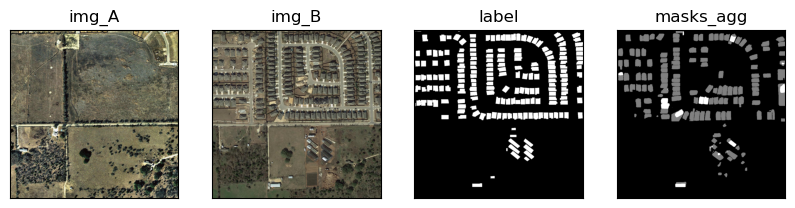

In [5]:
show_prediction_sample(output)

In [38]:
from magic_pen.data.process import generate_grid_prompt

def generate_prompt(mask, dtype: str, n_point, **kwargs) -> torch.Tensor:
    img_size = mask.shape[-1]
    match dtype:
        case "grid":
            point_per_side = int(np.sqrt(n_point)) 
            prompt = torch.as_tensor(generate_grid_prompt(point_per_side, img_size=img_size))
            labels = torch.ones(len(prompt))    
        case "sample":
            loc = kwargs.get('loc', "center")
            prompt, labels = PointSampler().sample(mask, n_point, loc=loc)
        case _:
            raise ValueError("Please provide valid prompt builder name")

    return prompt.to(torch.float32), labels.to(torch.int8)

In [39]:
class PointSampler:
    """Prompt sampler - restricted to points"""
    def sample(self, mask: torch.Tensor, n_point: int, loc: str, **kwargs):

        # empty return
        sample_coords = torch.zeros((n_point, 2))
        
        _register_sample_method = {
            "random": self.draw_random_point,
            "center": self.draw_center_point,
        }
        if loc not in list(_register_sample_method):
            raise ValueError(f"loc method not valid. Valid values for loc : {list(_register_sample_method)}")

        if mask.ndim < 3:
            mask = mask.unsqueeze(0)
            
        # extract shapes from mask
        shapes = extract_object_from_batch(mask).squeeze(0)
        # first check to prevent sum over all the masks
        if shapes.shape[0] > 1 or torch.sum(shapes):
            # draw selected shapes
            id_draw = torch.multinomial(torch.arange(shapes.shape[0], dtype=torch.float), n_point, replacement=False)
            # get the coord of the pixels shapes (M x 3) - M number of not zeros pixels
            coords_candidates = torch.nonzero(shapes[id_draw]).to(torch.float)
            # iterate over the shapes
            sample_coords = torch.stack(
                [
                    # sample on masked data based on shape index - ignore index dim => (N, 2)
                    _register_sample_method[loc](coords_candidates[coords_candidates[:,0] == s][:, 1:])
                for s in torch.unique(coords_candidates[:, 0])]
            )
        # simulate point type (foreground / background)
        labels_points = torch.ones(len(sample_coords))
        
        return sample_coords, labels_points

    def draw_random_point(self, shape):
        """draw one random point from shape"""
        idx = torch.multinomial(torch.arange(shape.shape[0], dtype=torch.float), num_samples=1).squeeze(0)
        return shape[idx]
            
    def draw_center_point(self, shape):
        return torch.mean(shape, dim=0).to(int)

In [40]:
label = output["batch"]["label"]

In [56]:
res, _ = generate_prompt(label, dtype="grid", n_point=10, loc="random")

In [59]:
res

tensor([[170.6667, 170.6667],
        [512.0000, 170.6667],
        [853.3333, 170.6667],
        [170.6667, 512.0000],
        [512.0000, 512.0000],
        [853.3333, 512.0000],
        [170.6667, 853.3333],
        [512.0000, 853.3333],
        [853.3333, 853.3333]])

In [57]:
# invert for sample

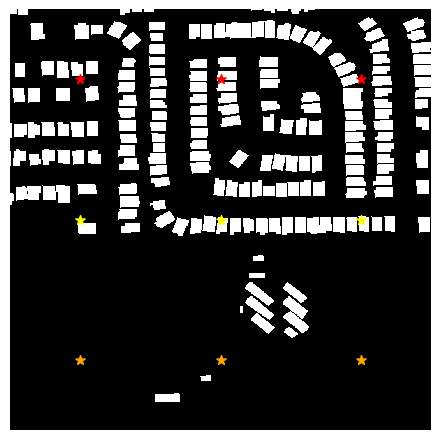

In [58]:
show_img(to_numpy(label.squeeze(0) > 0, transpose=False))
ax = plt.gca()
color = ["red", "yellow", "orange"] * len(res)
pts = to_numpy(res,transpose=False)
for pt,c in zip(pts, color):
    ax.scatter(*pt[::-1], color=c, marker='*', s=50)